Presented by: Reza Saadatyar <br/>
E-mail: Reza.Saadatyar92@gmail.com

**Importing the required Libraries**

In [2]:
import numpy as np
import seaborn as sns
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from matplotlib.colors import ListedColormap
from sklearn import decomposition, discriminant_analysis, 
 model_selection, linear_model, neural_network, svm, tree, naive_bayes, neighbors, ensemble, metrics

# from skfeature.function.similarity_based import fisher_score
# from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector

**Functions**

In [5]:
# ================================================= Plot data ============================================================
def plot_data(filtered_data, fs=None, first_point=0, last_point=100, val_ylim='', size_fig=(7,5), title='', display_figure="off"):
    
    if display_figure == "on":
        if filtered_data.shape[0] < filtered_data.shape[1]:
            filtered_data = filtered_data.T
            
        filtered_data = filtered_data[first_point:last_point,:]
        
        std = np.sort(np.std(filtered_data, axis=0))
        if len(std) > 100:
            std = np.std(std[1:len(std)-1])
        else:
            std = np.std(std)
        
        _, axs = plt.subplots(nrows=1, sharey='row', figsize=size_fig)
        offset = np.arange(filtered_data.shape[1]*std*val_ylim, 1, -std*val_ylim)
      
        if fs is not None and np.array(fs) > 0:
            time = (np.linspace(start=first_point/fs, stop=last_point/fs, num=len(filtered_data))).flatten()
            line = axs.plot(time, filtered_data + offset, linewidth=1)
            axs.set_xlabel('Time (sec)', fontsize=10)
        else:
            line = axs.plot(filtered_data + offset, linewidth=1)
            axs.set_xlabel('sample', fontsize=10)
        
        axs.set_title(title, fontsize=10)
        axs.set_yticks(offset)
        axs.set_yticklabels(["ch" + str(i) for i in range(1, filtered_data.shape[1] + 1)],  weight='bold')
        axs.tick_params(axis='x', labelsize=9)
        axs.tick_params(axis='y', labelsize=8)
        axs.set_ylabel('Channels', fontsize=10)
        axs.tick_params(axis='y', color='k', labelcolor='k')
        axs.grid(False)
        ytick_labels = plt.gca().get_yticklabels()
        for i, label in enumerate(ytick_labels):
            # line[i].set_color(line[i].get_color())
            label.set_color(line[i].get_color())
            
        axs.autoscale(enable=True, axis="x",tight=True)
        min = np.min(np.min(filtered_data + offset, axis=0))
        max = np.max(np.max(filtered_data + offset, axis=0))
        axs.set_ylim(min + min*0.02, max + max*0.01)

# ================================================== Data normalization ==================================================
def data_normalization(x_train, x_test, method="MinMaxScaler"):
    
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == "MinMaxScaler":
        norm = preprocessing.MinMaxScaler()
    elif method == "StandardScaler":
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test




# ================================================ Plot_classification =================================================== 
def plot_classification(data_train, label_train, data_test, label_test, model, k_fold, type_class, display_classification="off", display_normalize_classification="on", fig_size_classification=(5, 3)):
    # --------------------------------------------------- Data transpose -------------------------------------------------
    if display_classification == "on":
        if data_train.shape[0] < data_train.shape[1]:
            data_train = data_train.T
    
        if data_test.shape[0] < data_test.shape[1]:
            data_test = data_test.T   
        # ------------------------------------------ Predict the train & test labels -------------------------------------
        miss_class_train = label_train - model.predict(data_train)      # predict the train labels
        miss_class_train = len(miss_class_train[miss_class_train != 0])
        
        miss_class_test = label_test - model.predict(data_test)         # predict the test labels
        miss_class_test = len(miss_class_test[miss_class_test != 0]) 
        lab = np.unique(label_train)
        # ------------------------------------------------- Data normalization -------------------------------------------
        if display_normalize_classification=="on":
            if np.max(data_train) > 1:
                norm = preprocessing.MinMaxScaler()
                data_train = norm.fit_transform(data_train)
                data_test = norm.fit_transform(data_test)
        # --------------------------------------------------- Plot -------------------------------------------------------
        if data_train.shape[1] < 3:
   
            resolution = 0.03
            x_combined = np.vstack((data_train, data_test))
            y_combined = np.hstack((label_train, label_test))
            x1_min, x1_max = x_combined[:, 0].min() - 1, x_combined[:, 0].max() + 1
            x2_min, x2_max = x_combined[:, 1].min() - 1, x_combined[:, 1].max() + 1
            xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
            z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
            
            fig, axs = plt.subplots(1, 2, sharey='row', figsize=fig_size_classification, constrained_layout=True)
            colors = list(reversed(sns.color_palette("bright", len(lab)).as_hex()))
            cmp = ListedColormap(colors[:len(lab)])
            
            axs[0].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[0].set_xlim(xx1.min(), xx1.max())
            axs[0].set_ylim(xx2.min(), xx2.max())

            axs[1].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[1].set_xlim(xx1.min(), xx1.max())
            axs[1].set_ylim(xx2.min(), xx2.max())

            for i in range(0, len(np.unique(y_combined))):
                axs[0].plot(data_train[label_train==lab[i], 0], data_train[label_train==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
                axs[1].plot(data_test[label_test==lab[i], 0], data_test[label_test==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
            
            axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            
            axs[0].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[0].set_ylabel('Feature 2', fontsize=10, va='center')
            axs[0].set_title(f"Traininng; Miss_classes: {miss_class_train}#", loc='left', pad=0, fontsize=10) 
            axs[0].legend(title="Class", loc="best", fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0.2)
            
            axs[1].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[1].set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, fontsize=10)
            
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, fontweight='normal', color='black', va='top')
            
        elif data_train.shape[1] > 2:
           
            x_train = data_train[:, 0:3]
            x_test = data_test[:, 0:3]
        
            fig = plt.figure(figsize=(7.5,3.5))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')

            for i in range(0, len(lab)):
                ax1.plot3D(x_train[label_train==lab[i], 0], x_train[label_train==lab[i], 1], x_train[label_train==lab[i], 2], '.', label=lab[i])
                ax2.plot3D(x_test[label_test==lab[i], 0], x_test[label_test==lab[i], 1], x_test[label_test==lab[i], 2], '.')

            ax1.view_init(5, -120), ax2.view_init(5, -120) 
            ax1.set_xlabel('Feature 1', fontsize=10, va='center'), ax2.set_xlabel('Feature 1', fontsize=10, va='center')
            ax1.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center'), ax2.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center')
            ax1.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center', rotation=45)  
            
            ax1.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax2.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax1.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax2.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax1.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            ax2.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            
            ax1.legend(title="Class", loc=5, fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0)
            ax1.set_title(f"Traing; Miss_classes: {miss_class_train }#", loc='right', pad=0, y=0.8, fontsize=10)
            ax2.set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, y=0.8, fontsize=10),
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, x=0.51,  y=0.9, fontweight='normal', color='black', va='top')
                
            plt.tight_layout(w_pad=-1, h_pad=0), plt.subplots_adjust(top=1, bottom=0, left=0 ,wspace=-0.1, hspace=0)
            
        plt.autoscale(enable=True, axis="x", tight=True)
        # ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
    
# =================================================== KNN_optimal ========================================================  
def knn_optimal(data_train, label_train, data_test, label_test, display_optimal_k="off", n=21, fig_size=(3.5,2.5)):
    if np.shape(data_train)[0] < np.shape(data_train)[1]:  # Convert Data training & Test >>>> m*n; m > n
        data_train = data_train.T
        data_test = data_test.T
    t = np.arange(1, n)
    accuracy_train = np.zeros(n-1)
    accuracy_test = np.zeros(n-1)
    for i in range(1 , n):
        model = neighbors.KNeighborsClassifier(metric='minkowski', n_neighbors=i)
        model.fit(data_train, label_train)
        accuracy_train[i-1] = model.score(data_train, label_train)
        accuracy_test[i-1] = model.score(data_test, label_test)
    
    if display_optimal_k == "on":
        
        plt.figure(figsize=fig_size)
        plt.plot(t, accuracy_train, label="Training")
        plt.plot(t, accuracy_test, label="Test")
        plt.xticks(t)
        plt.legend(fontsize=8)
        
        plt.xlabel("Number of neighbors")
        plt.ylabel("Accuracy")
        plt.title(f"Optimal_k for KNN: {t[np.argmax(accuracy_test)]}", fontsize=10)
        plt.tick_params(axis='x', rotation=90)

    return t[np.argmax(accuracy_test)]

# ===================================================== Roc curve ======================================================== 
def roc_curve(model, data_train, data_test, label_train, label_test, k_fold, type_class, display_Roc_classes, fig_size_Roc=(5, 3)):
   # ----------------------- Initialize lists to store fpr, tpr, and roc_auc for each class ------------------------------
   fpr_tr, tpr_tr, fpr_te, tpr_te = dict(), dict(), dict(), dict()                                 
   roc_auc_tr, roc_auc_te = [], []
   mean_tpr_tr, mean_tpr_te = 0.0, 0.0
   mean_fpr = np.linspace(0, 1, 100)
   # ------------------------------------ Binarize the labels for each class ---------------------------------------------
   num_classes = np.max(label_train) + 1           
   label_tr = np.eye(num_classes)[label_train]  
   label_te = np.eye(num_classes)[label_test]  
   # ------------------------------------ Predict the labels for each class ---------------------------------------------
   y_scores_tr = model.predict_proba(data_train)   
   y_scores_te = model.predict_proba(data_test)   
   # --------------------------------------------- ROC curve for each class ---------------------------------------------
   for i in range(label_tr.shape[1]):            
      fpr_tr[i], tpr_tr[i], _ = metrics.roc_curve(label_tr[:, i], y_scores_tr[:, i])
      roc_auc_tr.append(metrics.auc(fpr_tr[i], tpr_tr[i]))
      mean_tpr_tr += np.interp(mean_fpr, fpr_tr[i], tpr_tr[i])  # Interpolate the mean_tpr at mean_fpr
      mean_tpr_tr[0] = 0.0
      
      fpr_te[i], tpr_te[i], _ = metrics.roc_curve(label_te[:, i], y_scores_te[:, i])
      roc_auc_te.append(metrics.auc(fpr_te[i], tpr_te[i]))
      mean_tpr_te += np.interp(mean_fpr, fpr_te[i], tpr_te[i])  # Interpolate the mean_tpr at mean_fpr
      mean_tpr_te[0] = 0.0
   # ------------------------ Calculate mean true positive rate across all folds and classes ----------------------------
   mean_tpr_tr = mean_tpr_tr/(i+1)                            
   mean_tpr_te = mean_tpr_te/(i+1)
   mean_auc_tr = metrics.auc(mean_fpr, mean_tpr_tr)
   mean_auc_te = metrics.auc(mean_fpr, mean_tpr_te)
   # ------------------------------------------- Plot ROC curve for each class -------------------------------------------
   if display_Roc_classes == "on":
      fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
      for i in range(label_tr.shape[1]):
         ax1.plot(fpr_tr[i], tpr_tr[i], lw=1.2, label=f"C{i}:{roc_auc_tr[i]:.2f}")
         ax2.plot(fpr_te[i], tpr_te[i], lw=1.2, label=f"C{i}:{roc_auc_te[i]:.2f}")
      # ----------------------------- # Compute macro-average ROC curve and ROC area ------------------------------------- 
      all_fpr_tr = np.unique(np.concatenate([fpr_tr[i] for i in range(label_tr.shape[1])]))# First aggregate all false positive rates
      all_fpr_te = np.unique(np.concatenate([fpr_te[i] for i in range(label_te.shape[1])]))
      avg_tpr_tr = np.zeros_like(all_fpr_tr)                                               # Then interpolate all ROC curves at this points
      avg_tpr_te = np.zeros_like(all_fpr_te)                                               
      for i in range(label_tr.shape[1]):
         avg_tpr_tr += np.interp(all_fpr_tr, fpr_tr[i], tpr_tr[i])
         avg_tpr_te += np.interp(all_fpr_te, fpr_te[i], tpr_te[i])
         
      avg_tpr_tr /= label_tr.shape[1]                                                      # Finally average it and compute AUC
      avg_tpr_te /= label_te.shape[1] 
      fpr_tr[i+1] = all_fpr_tr
      fpr_te[i+1] = all_fpr_te
      tpr_tr[i+1] = avg_tpr_tr
      tpr_te[i+1] = avg_tpr_te
      roc_auc_tr.append(metrics.auc(fpr_tr[i+1], tpr_tr[i+1]))
      roc_auc_te.append(metrics.auc(fpr_te[i+1], tpr_te[i+1]))
      # -------------------------------- # Compute micro-average ROC curve and ROC area ----------------------------------
      fpr_tr[i+2], tpr_tr[i+2], _ = metrics.roc_curve(label_tr.ravel(), y_scores_tr.ravel())
      roc_auc_tr.append(metrics.auc(fpr_tr[i+2], tpr_tr[i+2]))
      fpr_te[i+2], tpr_te[i+2], _ = metrics.roc_curve(label_te.ravel(), y_scores_te.ravel())
      roc_auc_te.append(metrics.auc(fpr_te[i+2], tpr_te[i+2]))
      # ------------------------------------ Plot Macro avg & Micro avg --------------------------------------------------
      ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
      ax1.plot(fpr_tr[i+1], tpr_tr[i+1] , color='blue', linestyle='-', lw=1.2, label=f"Macro avg:{roc_auc_tr[i+1]:.2f}")
      ax1.plot(fpr_tr[i+2], tpr_tr[i+2] , color='g', linestyle='-', lw=1.2, label=f"Micro avg:{roc_auc_tr[i+2]:.2f}")
      ax1.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
      ax1.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
      ax1.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
      ax1.set_xlabel('False Positive Rate (FPR)', fontsize=10), ax1.set_ylabel('True Positive Rate (TPR)', fontsize=10)

      ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
      ax2.plot(fpr_te[i+1], tpr_te[i+1] , color='blue', linestyle='-', lw=1.2, label=f"Macro avg:{roc_auc_te[i+1]:.2f}")
      ax2.plot(fpr_te[i+2], tpr_te[i+2] , color='g', linestyle='-', lw=1.2, label=f"Micro avg:{roc_auc_te[i+2]:.2f}")
      ax2.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
      ax2.set_xlabel('False Positive Rate (FPR)', fontsize=10)
      ax2.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
      ax2.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
       
      plt.autoscale(axis="x", tight=True, enable=True)
      fig1.suptitle(f"{type_class} ROC Curve for a {k_fold+1}_fold cross-validation", fontsize=10)
        
   return mean_tpr_tr, mean_tpr_te, mean_auc_tr, mean_auc_te 

# ================================================= Display all kfold ==================================================== 
def roc_curve_all_kfold(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold="off", display_Roc_classification="off", fig_size_Roc=(4, 3)):

    mean_fpr = np.linspace(0, 1, 100)
    if display_Roc_classification == "on":
        axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[0].plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_tr):.2f}")
        axs[1].plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_te):.2f}")
        axs[0].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03), axs[1].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)        
        axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[0].set_xlabel('False Positive Rate (FPR)', fontsize=10), axs[1].set_xlabel('False Positive Rate (FPR)', fontsize=10)
        axs[0].set_ylabel('True Positive Rate (TPR)', fontsize=10)
        axs[0].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        axs[1].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        plt.autoscale(axis="x", tight=True, enable=True)
        fig.suptitle(f"ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)

    if display_all_kfold=="on":
        fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
        ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
    
        for j in range(0, k_fold):
            
            ax1.plot(mean_fpr, tpr_tr[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_tr[j]:.2f}")
            ax2.plot(mean_fpr, tpr_te[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_te[j]:.2f}")

        tprs_upper_tr = np.minimum(np.mean(tpr_tr, axis=1) + np.std(tpr_tr, axis=1), 1)
        tprs_lower_tr = np.maximum(np.mean(tpr_tr, axis=1) - np.std(tpr_tr, axis=1), 0)
        tprs_upper_te = np.minimum(np.mean(tpr_te, axis=1) + np.std(tpr_te, axis=1), 1)
        tprs_lower_te = np.maximum(np.mean(tpr_te, axis=1) - np.std(tpr_te, axis=1), 0)
            
        ax1.fill_between(mean_fpr, tprs_lower_tr, tprs_upper_tr, color='grey', alpha=.2, label=r'$\pm$  std')
        ax1.plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
        ax2.fill_between(mean_fpr, tprs_lower_te, tprs_upper_te, color='grey', alpha=.2, label=r'$\pm$  std')
        ax2.plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
            
        ax1.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax1.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax1.set_xlabel('False Positive Rate (FPR)', fontsize=10), ax1.set_ylabel('True Positive Rate (TPR)', fontsize=10)
        ax1.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)

        ax2.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax2.set_xlabel('False Positive Rate (FPR)', fontsize=10)
        ax2.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax2.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
            
        plt.autoscale(axis="x", tight=True, enable=True)
        fig1.suptitle(f"{type_class} ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)
    
# ================================================== classification ====================================================== 
def classification(model, data, labels, fig, axs, k_fold=5, normalize_active="off", method="MinMaxScaler",  display_fold_classification=1, display_classification="off", display_normalize_classification="off", display_Roc_classes="off", display_all_kfold="off", display_Roc_classification="off",fig_size_Roc=(5, 3), fig_size_classification=(5, 3), display_optimal_k="off", type_class="LR"):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
   cv = model_selection.StratifiedKFold(n_splits=k_fold)     
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
   tpr_tr = np.zeros((100, k_fold))
   tpr_te = np.zeros((100, k_fold))
   auc_tr = np.zeros(k_fold)
   auc_te = np.zeros(k_fold)
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te = [], [], [], [], [], [],[], []
   
   for j, (train, test) in enumerate(cv.split(data, labels)):  
      # --------------------------------------------------- Split data ------------------------------------------------------------
      data_train = data[train] 
      data_test = data[test]
      label_train = labels[train]
      label_test = labels[test]
      # -------------------------------------------------- Data normalization -----------------------------------------------------
      if normalize_active == "on": 
          data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
      # ------------------------------------------------------ KNN methods --------------------------------------------------------
      if type_class == "KNN":
            num_k = knn_optimal(data_train, label_train, data_test, label_test, display_optimal_k, n=21, fig_size=(3.5,2.5))  # Obtain optimal K
            model = neighbors.KNeighborsClassifier(n_neighbors=num_k, weights='uniform', metric='minkowski')
      # ---------------------------------------------------- Training Network -----------------------------------------------------
      model.fit(data_train, label_train)                                           # Fit i.e., Training
      # ---------------------------------------------- Training Section -----------------------------------------------------------
      label_predict_train = model.predict(data_train)
      accuracy_tr.append(metrics.accuracy_score(label_train, label_predict_train)) # Calculate accuracy  
      f1_tr.append(metrics.f1_score(label_train, label_predict_train, average='weighted')) # Calculate F1 score
      precision_tr.append(metrics.precision_score(label_train, label_predict_train, average='weighted'))  # Calculate precision
      recall_tr.append(metrics.recall_score(label_train, label_predict_train, average='weighted'))   # Calculate recall
      # ----------------------------------------------- Test Section --------------------------------------------------------------
      label_predict_test = model.predict(data_test)
      accuracy_te.append(metrics.accuracy_score(label_test, label_predict_test)) # Calculate accuracy  
      f1_te.append(metrics.f1_score(label_test, label_predict_test, average='weighted')) # Calculate F1 score
      precision_te.append(metrics.precision_score(label_test, label_predict_test, average='weighted'))  # Calculate precision
      recall_te.append(metrics.recall_score(label_test, label_predict_test, average='weighted'))   # Calculate recall
      # cr_test = metrics.classification_report(label_test, label_predict_test, labels=np.unique(label_test))
      # --------------------------------------------- Compute ROC curve and area the curve ----------------------------------------
      tpr_tr[:, j], tpr_te[:, j], auc_tr[j], auc_te[j] = roc_curve(model, data_train, data_test, label_train, label_test, j, type_class,display_Roc_classes, fig_size_Roc)
      
      if display_fold_classification == j:
          plot_classification(data_train, label_train, data_test, label_test, model, j, type_class, display_classification, display_normalize_classification, fig_size_classification)

   roc_curve_all_kfold(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold, display_Roc_classification, fig_size_Roc)
   
   return accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_class

# =================================================== Performance ======================================================== 
def performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te, type_method, k_fold, fig_size=(7, 3)):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size, sharey="row", constrained_layout=True)

    mean_tr = [np.mean(accuracy_tr, axis=1), np.mean(f1_tr, axis=1), np.mean(precision_tr, axis=1), np.mean(recall_tr, axis=1)]
    std_tr = [np.std(accuracy_tr, axis=1), np.std(f1_tr, axis=1), np.std(precision_tr, axis=1), np.std(recall_tr, axis=1)]
    mean_te = [np.mean(accuracy_te, axis=1), np.mean(f1_te, axis=1), np.mean(precision_te, axis=1), np.mean(recall_te, axis=1)]
    std_te = [np.std(accuracy_te, axis=1), np.std(f1_te, axis=1), np.std(precision_te, axis=1), np.std(recall_te, axis=1)]

    bar_width = 1  # Change the bar width as needed
    x_label_distance = 3  # Adjust the distance between x-labels

    index = np.arange(len(type_method)) * (2*bar_width + x_label_distance)  # Create an array of x-values based on the bar width and distance

    for i, label in enumerate(['Accuracy', 'F1', 'Precision', 'Recall']):
        axs[0].bar(index + i * bar_width, mean_tr[i], bar_width, yerr=std_tr[i], capsize=2, label=label)
        axs[1].bar(index + i * bar_width, mean_te[i], bar_width, yerr=std_te[i], capsize=2, label=label)

    axs[0].set_title("Training", fontsize=10, pad=0, loc="left")
    axs[0].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    axs[0].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[0].legend(fontsize=9.5, loc="best", ncol=2, handlelength=0, handletextpad=0.25, frameon=True, labelcolor='linecolor') 
    axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True)
    axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0, rotation=90)

    axs[1].set_title("Test", fontsize=10, pad=0, loc="right")
    axs[1].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    fig.suptitle(f"Performance Metrics for Different Classifiers for a {k_fold}_fold cross-validation", fontsize=10)
    axs[1].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True)
    axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0, rotation=90)
    
# ============================================== Classification methods ================================================== 
def classification_methods(data, labels, k_fold, max_iter, solver_LR, hidden_layer_MLP, lr_MLP, kernel_SVM, C_SVM, criterion, lr_AdaBoost, lr_XGBoost,
                           n_estimators, max_depth, solver_LDA, LR, MLP, SVM, DT, NB, RF, AdaBoost, XGBoost, LDA, KNN,
                           normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, fig_size_performance, display_optimal_k):
                           
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te = [], [], [], [], [], []
   recall_tr, recall_te, type_method = [], [], []
   
   if display_Roc_classification == "on":
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
   else:
      fig, axs = [], []
   # ------------------------------------------------------ Logistic Regression -------------------------------------------------------
   if LR == "on":
      model = linear_model.LogisticRegression(C=1, max_iter=max_iter, solver=solver_LR, penalty='l2', multi_class="multinomial", verbose=0)
      
      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="LR")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # ----------------------------------------------------------- MLP ------------------------------------------------------------------
   if MLP == "on":
      model = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_MLP, max_iter=500, alpha=1e-4, learning_rate='invscaling', solver='adam',
                                       random_state=1, learning_rate_init=lr_MLP, verbose=False , tol=1e-4)    

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="MLP")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # ------------------------------------------------------------- SVM ----------------------------------------------------------------
   if SVM == "on":
      model = svm.SVC(kernel=kernel_SVM, random_state=0, C=C_SVM, gamma="auto", probability=True) 
     
      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="SVM")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # -------------------------------------------------------------- DT ------------------------------------------------------------------
   if DT == "on":
      model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="DT")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- NB ------------------------------------------------------------------
   if NB == "on":
      model = naive_bayes.GaussianNB()

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="NB")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- RF ------------------------------------------------------------------
   if RF == "on":
      model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion="gini", random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="RF")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ----------------------------------------------------------- AdaBoost ---------------------------------------------------------------
   if AdaBoost == "on":
      #  # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
      # # model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
      model = ensemble.AdaBoostClassifier(n_estimators=n_estimators, learning_rate=lr_AdaBoost, random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="AdaBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ------------------------------------------------------------ XGBoost ---------------------------------------------------------------
   if XGBoost == "on":
      model = XGBClassifier(max_depth=5, n_estimators=n_estimators, learning_rate=lr_XGBoost, random_state=0, objective='multi:softpr_teob')

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="XGBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- LDA -----------------------------------------------------------------
   if LDA == "on":
      model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1, solver=solver_LDA)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,fig_size_classification, display_optimal_k, type_class="LDA")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- KNN -----------------------------------------------------------------
   if KNN == "on":
      model = []

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="KNN")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),

   performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te, type_method, k_fold, fig_size_performance)
   

**3. Filtering**<br/>

`Fs > f_high > f_low`

In [8]:
filtered_data = Filfiltering(data, f_low=3, f_high=10, order=3, fs=50, filter_type="low")    # btype:'low','high','bandpass','bandstop'
plot_data(filtered_data, fs=None, first_point=0, last_point=500, val_ylim=3, size_fig=(7,5), title='filtered_data', display_figure="off")

**4. Split data, Data normalization, & Classification**<br/>

`data_train, data_test, label_train, label_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)`<br/>
`data_train, data_test = data_normalization(data_train, data_test, method=2)   # method 1: MinMaxScaler, method 2: StandardScaler` <br/>

The advantages of support vector machines are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Decision Tree:
- def error(p):<br/>
    return 1 - np.max([p, 1 - p])
- def gini(p):<br/>
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
- def entropy(p):<br/>
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
   -  penalty ---> elasticnet: both L1 and L2 penalty terms are added.
   - Supported penalties by solver: lbfgs-->[l2, None]; liblinear-->[l1, l2]; newton-cg-->[l2, None]; newton-cholesky-->[l2, None]; sag-->[l2, None]; saga-->[elasticnet, l1, l2, None]
   - sag and saga fast convergence is only guaranteed on features with approximately the same scale.
   - For small datasets, liblinear is a good choice, whereas sag and saga are faster for large ones; For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss;
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM]()
  - kernel_svm = "linear"   # poly, rbf, sigmoid, precomputed, if 'poly'---> degree=3
  - c ---> Regularization parameter

- `Micro-average ROC curve:`Micro-averaging combines all classes to create a single ROC curve by treating all true positives, false positives, and false negatives as if they belong to one class. This provides an overall performance measure for the classifier without considering differences between individual classes (Aggregates performance metrics by considering all instances (regardless of class) as if they belong to a single class).
- `Macro-Average ROC Curve:`Calculate the ROC curve for each class individually, and then average the results. Each class is given equal importance, and the macro-average ROC curve gives an overall view of how well the classifier performs across different classes. This approach is not affected by imbalances in class distribution (Averages performance metrics across different classes, treating each class equally).<br/>
If the classes are imbalanced, micro-averaging may be influenced more by the larger classes. Macro-averaging treats each class equally, which can provide a balanced evaluation across all classes.

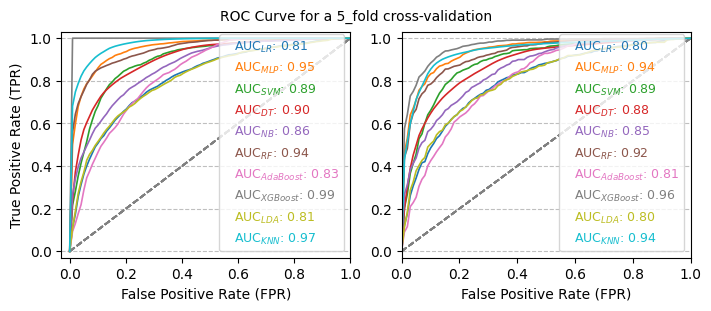

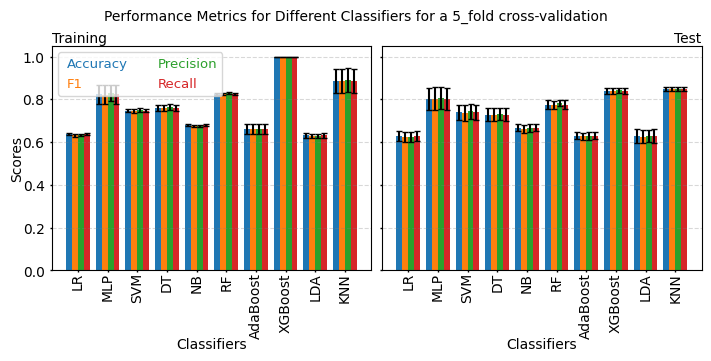

In [10]:
k_fold = 5
max_iter = 1000                                  # Max_iter for LR
solver_LR = 'lbfgs'                              # Solver for LR lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga; for 
solver_LDA = "svd"                               # svd, lsqr, eigen
n_estimators = 300                               # N_estimators for RF, AdaBoost, XGBoost
max_depth = 3                                    # Max_depth for DT, RF, XGBoost
hidden_layer_MLP = (10, 10)
lr_MLP = 0.05
lr_AdaBoost = 0.1
lr_XGBoost = 0.1
kernel_SVM ="rbf"                                # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
C_SVM = 10

criterion = "gini"                               # gini, entropy, log_loss for DT and RF

method = "MinMaxScaler"                          # MinMaxScaler" , StandardScaler for data normalization 
normalize_active = "on"                          # normalize_active for data normalization

display_fold_classification = 2                  # Plot train and test data in k_fold eg., 1
display_classification = "off"                   # Display train and test data in k_fold eg., 1
display_normalize_classification ="off"          # Display train and test data is normalized

display_Roc_classes = "off"                      # Display Roc curve for all classes in each k-fold
display_all_kfold = "off"                        # Display Roc curve for each k-fold only
display_Roc_classification = "on"                # Display the average Roc curve of all k-folds for each classification

display_optimal_k = "off"                        # Display k optimal neighbors for KNN


fig_size_Roc = (7, 3)
fig_size_classification = (5, 3)
fig_size_performance = (7, 3.5) 
LR = "on"
MLP = "on"
SVM = "on"
DT = "on"
NB = "on"
RF = "on"
AdaBoost = "on"
XGBoost = "on"
LDA = "on"
KNN = "on"
classification_methods(data, labels, k_fold, max_iter, solver_LR, hidden_layer_MLP, lr_MLP, kernel_SVM, C_SVM, criterion, lr_AdaBoost, lr_XGBoost, n_estimators, max_depth, solver_LDA, LR, MLP, SVM, DT, NB, RF, AdaBoost, XGBoost, LDA, KNN,                          
normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, fig_size_performance, display_optimal_k)

In [ ]:

from sklearn import datasets
from Filtering import filtering
from Clustering import clustering
from Preparing_data import preparing_data
from Normalize import normalize_data
from Classification import classification
from Plot_clustering import plot_cluster
from Feature_Selection import featureselection
from Feature_Extraction import feature_extraction
from Output_Training_Test_Network import output_network


# ======================================= Step 3: Feature Extraction & Selection =======================================
# ===================================== Step 4: Classification & Clustering ==========================================
# ----------------------------------------- Step 4: Classification ---------------------------------------------------

Accuracy_Train, Cr_Train, Accuracy_Test, Cr_Test = output_network(Data, Labels, model, type_class, k_fold=5)
"""
type_class: 'KNN', 'LR', 'MLP', 'SVM', 'DT', 'NB', 'RF', 'AdaBoost', 'XGBoost', 'LDA'

LR: LogisticRegression; MLP: Multilayer perceptron, SVM:Support Vector Machine; DT: Decision Tree; NB: Naive Bayes;
RF: Random Forest; AdaBoost; XGBoost; LDA: Linear Discriminant Analysis; KNN:K-Nearest Neighbors 
Parameters:
The number of hidden layers: hidden_layer_mlp; The number of epochs MLP: max_iter,

max_depth=The maximum depth of the tree, random forest and XGBoost;;
n_estimators:The number of trees in the forest.
"""
# ----------------------------------------- Step 4: Clustering -----------------------------------------------------
clustering(Data, n_clusters=3, max_iter=100, thr_brich=0.5,  branchfactor_brich=50, n_neighbor_SpecCluster=10,
           minsamples_optics=15, max_dist_optics=5, batch_size_MBKmeans=10, type_cluster='MiniBatchKMeans')
"""
type_cluster: kmeans; Agglomerative; DBSCAN; GMM:Gaussian Mixture Models; Meanshift; Birch; SpectralClustering; 
OPTICS; MiniBatchKMeans
"""


In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.8)

In [ ]:
from scipy import stats
mpg = [21.0, 21.0, 22.8, 21.4, 18.7, 18.1, 14.3, 24.4, 22.8, 19.2, 17.8, 16.4, 17.3, 15.2, 10.4, 10.4, 14.7, 32.4, 30.4,
       33.9, 21.5, 15.5, 15.2, 13.3, 19.2, 27.3, 26.0, 30.4, 15.8,19.7, 15.0, 21.4]

hp = [110, 110, 93, 110, 175, 105, 245, 62, 95, 123, 123, 180,180, 180, 205, 215, 230, 66, 52, 65, 97, 150, 150, 245,
     175, 66, 91, 113, 264, 175, 335, 109]

stats.pearsonr(mpg, hp)

stats.spearmanr(mpg,hp)
stats.spearmanr(mpg,hp)

In [ ]:
country1 = np.array([176., 179., 180., 188., 187., 184., 171., 201., 172.,
                     181., 192., 187., 178., 178., 180., 199., 185., 176.,
                     207., 177., 160., 174., 176., 192., 189., 187., 183.,
                     180., 181., 200., 190., 187., 175., 179., 181., 183.,
                     171., 181., 190., 186., 185., 188., 201., 192., 188.,
                     181., 172., 191., 201., 170., 170., 192., 185., 167.,
                     178., 179., 167., 183., 200., 185.])

country2 = np.array([ 177., 165., 175., 172., 179., 192., 169., 185., 187.,
                      167., 162., 165., 188., 194., 187., 175., 163., 178.,
                      197., 172., 175., 185., 176., 171., 172., 186., 168.,
                      178., 191., 192., 175., 189., 178., 181., 170., 182.,
                      166., 189., 196., 192., 189., 171., 185., 198., 181.,
                      167., 184., 179., 178., 193., 179., 177., 181., 174.,
                      171., 184., 156., 180., 181., 187.])

country3 = np.array([191., 190., 191., 185., 190., 184., 173., 175., 200.,
                     190., 191., 184., 167., 194., 195., 174., 171., 191.,
                     174., 177., 182., 184., 176., 180., 181., 186., 179.,
                     176., 186., 176., 184., 194., 179., 171., 174., 174.,
                     182., 198., 180., 178., 200., 200., 174., 202., 176.,
                     180., 163., 159., 194., 192., 163., 194., 183., 190.,
                     186., 178., 182., 174., 178., 182.])
stats.f_oneway(country1, country2, country3)

In [ ]:
clf.feature_importances_
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100)
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)
